In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams.update({'font.size':20})
plt.rcParams["figure.figsize"] = (12,10)

In [3]:
str_files = ''
#Carrega os dados do arquivo .csv
#df = pd.read_csv(str_files + "ph.csv",encoding='utf-8',sep=';')
dateparse = lambda dates:pd.datetime.strptime(dates,'%d/%m/%Y')
df = pd.read_csv(str_files + 'ph.CSV',encoding='utf-8',sep=';', parse_dates = ['data_coleta'],index_col=['data_coleta'],date_parser=dateparse)

/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [4]:
#Seleciona os dados da UGRHI 10 - SOROCABA/MEDIO TIETE
z = df.loc[df['UGRHI'] == '10 - SOROCABA/MEDIO TIETE']

In [5]:
#Agrupa os dados pela media bimestral
trainingd = z.resample('2M').mean()

In [6]:
trainingd
#Remove as colunas que não serão utilizadas no experimento.
trainingd = trainingd.drop(['cod_interaguas', 'sinal','Altitude'], axis=1)
trainingd

,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [7]:
#Regra 1.5*FIG --> Calcula-se o limite inferior e superior do diagrama de caixa.

#Ordena o dataframe
trainingds = trainingd.sort_values('valor',axis=0)

trainingds

tamanho = len(trainingds)
#Calcula o 1Q, ou seja, os primeiros 25% do diagrama de caixa.
primeiro_quartil = trainingds.quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear')
#Calcula o 3Q, ou seja, 75% do diagrama de caixa.
terceiro_quartil = trainingds.quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear')

print('primeiro_quartil:',primeiro_quartil)
print('terceiro_quartil:',terceiro_quartil)

#Calcula-se o interquartil(FIQ).
fig = terceiro_quartil - primeiro_quartil
print('fig:',fig)

#Calcula o limite inferior.
inferior = primeiro_quartil - (1.5*fig)
#Calcula o limite superior.
superior = terceiro_quartil + (1.5*fig)

print('Inferior:',inferior)
print('Superior:',superior)

#Seleciona os valores abaixo  do limite inferior, ou seja, os outlier.
outlier = trainingd[(trainingds.valor < 6.34725)]

outlier

primeiro_quartil: valor    6.9
Name: 0.25, dtype: float64
terceiro_quartil: valor    7.2685
Name: 0.75, dtype: float64
fig: valor    0.3685
dtype: float64
Inferior: valor    6.34725
dtype: float64
Superior: valor    7.82125
dtype: float64


/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,valor
data_coleta,
1987-01-31,6.2


In [8]:
#Substituição do outlier pelo valor médio da serie dos dados.
trainingd.loc[trainingd['valor'] == 6.20] = 7.08

ugrhi10 = trainingd

outlier = trainingd[(trainingd.valor < 6.34725)]

outlier

,valor
data_coleta,


In [9]:
ugrhi10

,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [10]:
#Seleciona os dados da UGRHI 10 - SOROCABA/MEDIO TIETE
z = df.loc[df['UGRHI'] == '06 - ALTO TIÊTE']

In [11]:
#Agrupa os dados pela media bimestral
trainingd = z.resample('2M').mean()

In [12]:
trainingd
#Remove as colunas que não serão utilizadas no experimento.
trainingd = trainingd.drop(['cod_interaguas', 'sinal','Altitude'], axis=1)
trainingd

,valor
data_coleta,
1978-01-31,6.680000
1978-03-31,6.680000
1978-05-31,6.440000
1978-07-31,6.560000
1978-09-30,6.110000
...,...
2019-01-31,7.056429
2019-03-31,7.323333
2019-05-31,7.405000


In [13]:
for field in trainingd.columns:
    print(field, 'NaN:', trainingd[field].isnull().sum())

valor NaN: 2


In [14]:
trainingd = trainingd.dropna(axis=0,how='any')


In [15]:
for field in trainingd.columns:
    print(field, 'NaN:', trainingd[field].isnull().sum())
trainingd

valor NaN: 0


,valor
data_coleta,
1978-01-31,6.680000
1978-03-31,6.680000
1978-05-31,6.440000
1978-07-31,6.560000
1978-09-30,6.110000
...,...
2019-01-31,7.056429
2019-03-31,7.323333
2019-05-31,7.405000


In [16]:
#Regra 1.5*FIG --> Calcula-se o limite inferior e superior do diagrama de caixa.

#Ordena o dataframe
trainingds = trainingd.sort_values('valor',axis=0)

trainingds

tamanho = len(trainingds)
#Calcula o 1Q, ou seja, os primeiros 25% do diagrama de caixa.
primeiro_quartil = trainingds.quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear')
#Calcula o 3Q, ou seja, 75% do diagrama de caixa.
terceiro_quartil = trainingds.quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear')

print('primeiro_quartil:',primeiro_quartil)
print('terceiro_quartil:',terceiro_quartil)

#Calcula-se o interquartil(FIQ).
fig = terceiro_quartil - primeiro_quartil
print('fig:',fig)

#Calcula o limite inferior.
inferior = primeiro_quartil - (1.5*fig)
#Calcula o limite superior.
superior = terceiro_quartil + (1.5*fig)

print('Inferior:',inferior)
print('Superior:',superior)

#Seleciona os valores abaixo  do limite inferior, ou seja, os outlier.
outlier = trainingd[(trainingds.valor < inferior.valor)]

outlier

primeiro_quartil: valor    6.583333
Name: 0.25, dtype: float64
terceiro_quartil: valor    7.002667
Name: 0.75, dtype: float64
fig: valor    0.419333
dtype: float64
Inferior: valor    5.954333
dtype: float64
Superior: valor    7.631667
dtype: float64


/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,valor
data_coleta,
1979-11-30,5.916667
1985-03-31,5.883333


In [17]:
trainingd

,valor
data_coleta,
1978-01-31,6.680000
1978-03-31,6.680000
1978-05-31,6.440000
1978-07-31,6.560000
1978-09-30,6.110000
...,...
2019-01-31,7.056429
2019-03-31,7.323333
2019-05-31,7.405000


In [18]:
#Remove a última linha do dataframe
trainingd = trainingd.drop(trainingd[trainingd.index == '2019-09-30'].index)

In [19]:
trainingd.describe()

,valor
count,248.000000
mean,6.793328
std,0.294764
min,5.883333
25%,6.581944
50%,6.838095
75%,7.001821
max,7.405000


In [20]:
#Substituição do outlier pelo valor médio da serie dos dados.
trainingd.loc[trainingds.valor < inferior.valor] = 6.79

ugrhi06 = trainingd

outlier = trainingd[(trainingd.valor < inferior.valor)]

outlier

,valor
data_coleta,


In [21]:
#Dados completo.
dataugrhi10 = ugrhi10.iloc[:,:].values
dataugrhi06 = ugrhi06.iloc[:,:].values
#treino (70%)
train10 = ugrhi10.iloc[0:int(len(dataugrhi10)*0.70),:].values  
train06 = ugrhi06.iloc[0:int(len(dataugrhi06)*0.70),:].values

#teste (30%)
test10 = ugrhi10.iloc[len(train10):,:].values 
test06 = ugrhi06.iloc[len(train06):,:].values

teste_observado = test06

In [22]:
#Normalização dos dados: Normaliza os dados dentro um intervalo (0 a 1).
sc = MinMaxScaler()
train10 = sc.fit_transform(train10)
#train06 = sc.fit_transform(train06)
test10 = sc.fit_transform(test10)
test06 = sc.fit_transform(test06)

In [23]:
def mape(y_pred,y_true):
    mape_sum = 0
    for real,prediction in zip(y_true,y_pred):
        mape_sum += (abs((real - prediction))/real)
        mape = mape_sum/len(real)
    return mape

def rmse(y_pred,y_true):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

def r2(y_pred,y_true):
    rscore = r2_score(y_true,y_pred)
    return rscore

In [24]:
def prepara_dados(dados,lags):
    X = []
    y = []
    for i in range(lags, len(dados)):
        X.append(dados[i-lags:i, 0])
        y.append(dados[i, 0])
    return np.array(X), np.array(y)

Train on 170 samples
Epoch 1/100
170/170 [==============================] - 0s 3ms/sample - loss: 0.4668 - mean_absolute_error: 0.4668
Epoch 2/100
170/170 [==============================] - 0s 82us/sample - loss: 0.4088 - mean_absolute_error: 0.4088
Epoch 3/100
170/170 [==============================] - 0s 131us/sample - loss: 0.3544 - mean_absolute_error: 0.3544
Epoch 4/100
170/170 [==============================] - 0s 107us/sample - loss: 0.3027 - mean_absolute_error: 0.3027
Epoch 5/100
170/170 [==============================] - 0s 133us/sample - loss: 0.2539 - mean_absolute_error: 0.2539
Epoch 6/100
170/170 [==============================] - 0s 136us/sample - loss: 0.2105 - mean_absolute_error: 0.2105
Epoch 7/100
170/170 [==============================] - 0s 176us/sample - loss: 0.1712 - mean_absolute_error: 0.1712
Epoch 8/100
170/170 [==============================] - 0s 110us/sample - loss: 0.1444 - mean_absolute_error: 0.1444
Epoch 9/100
170/170 [==============================] -

170/170 [==============================] - 0s 302us/sample - loss: 0.1189 - mean_absolute_error: 0.1189
Epoch 71/100
170/170 [==============================] - 0s 172us/sample - loss: 0.1187 - mean_absolute_error: 0.1187
Epoch 72/100
170/170 [==============================] - 0s 46us/sample - loss: 0.1187 - mean_absolute_error: 0.1187
Epoch 73/100
170/170 [==============================] - 0s 99us/sample - loss: 0.1183 - mean_absolute_error: 0.1183
Epoch 74/100
170/170 [==============================] - 0s 125us/sample - loss: 0.1186 - mean_absolute_error: 0.1186
Epoch 75/100
170/170 [==============================] - 0s 151us/sample - loss: 0.1200 - mean_absolute_error: 0.1200
Epoch 76/100
170/170 [==============================] - 0s 74us/sample - loss: 0.1189 - mean_absolute_error: 0.1189
Epoch 77/100
170/170 [==============================] - 0s 102us/sample - loss: 0.1185 - mean_absolute_error: 0.1185
Epoch 78/100
170/170 [==============================] - 0s 180us/sample - loss: 

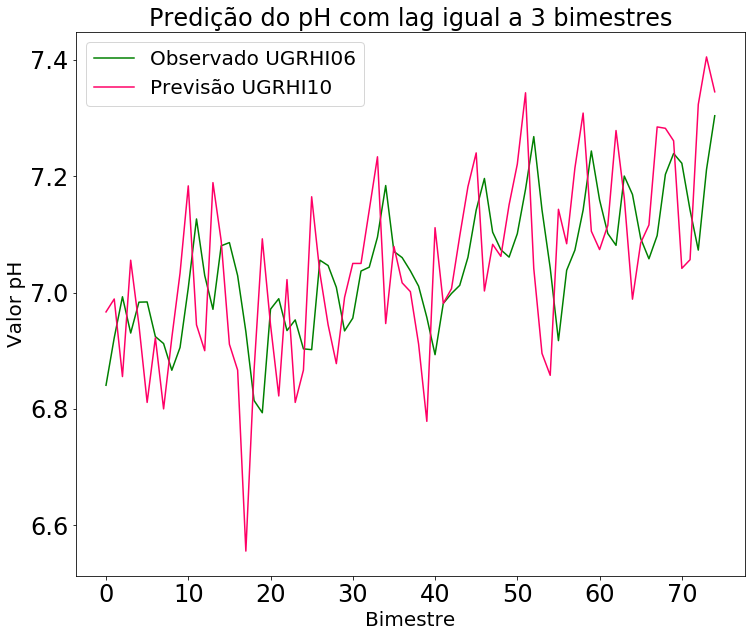

Train on 168 samples
Epoch 1/100
168/168 [==============================] - 0s 2ms/sample - loss: 0.1410 - mean_absolute_error: 0.1410
Epoch 2/100
168/168 [==============================] - 0s 127us/sample - loss: 0.1378 - mean_absolute_error: 0.1378
Epoch 3/100
168/168 [==============================] - 0s 134us/sample - loss: 0.1375 - mean_absolute_error: 0.1375
Epoch 4/100
168/168 [==============================] - 0s 122us/sample - loss: 0.1363 - mean_absolute_error: 0.1363
Epoch 5/100
168/168 [==============================] - 0s 155us/sample - loss: 0.1357 - mean_absolute_error: 0.1357
Epoch 6/100
168/168 [==============================] - 0s 111us/sample - loss: 0.1347 - mean_absolute_error: 0.1347
Epoch 7/100
168/168 [==============================] - 0s 147us/sample - loss: 0.1341 - mean_absolute_error: 0.1341
Epoch 8/100
168/168 [==============================] - 0s 120us/sample - loss: 0.1330 - mean_absolute_error: 0.1330
Epoch 9/100
168/168 [==============================] 

168/168 [==============================] - 0s 92us/sample - loss: 0.1216 - mean_absolute_error: 0.1216
Epoch 71/100
168/168 [==============================] - 0s 118us/sample - loss: 0.1211 - mean_absolute_error: 0.1211
Epoch 72/100
168/168 [==============================] - 0s 177us/sample - loss: 0.1217 - mean_absolute_error: 0.1217
Epoch 73/100
168/168 [==============================] - 0s 121us/sample - loss: 0.1212 - mean_absolute_error: 0.1212
Epoch 74/100
168/168 [==============================] - 0s 171us/sample - loss: 0.1210 - mean_absolute_error: 0.1210
Epoch 75/100
168/168 [==============================] - 0s 141us/sample - loss: 0.1206 - mean_absolute_error: 0.1206
Epoch 76/100
168/168 [==============================] - 0s 156us/sample - loss: 0.1210 - mean_absolute_error: 0.1210
Epoch 77/100
168/168 [==============================] - 0s 122us/sample - loss: 0.1212 - mean_absolute_error: 0.1212
Epoch 78/100
168/168 [==============================] - 0s 248us/sample - loss

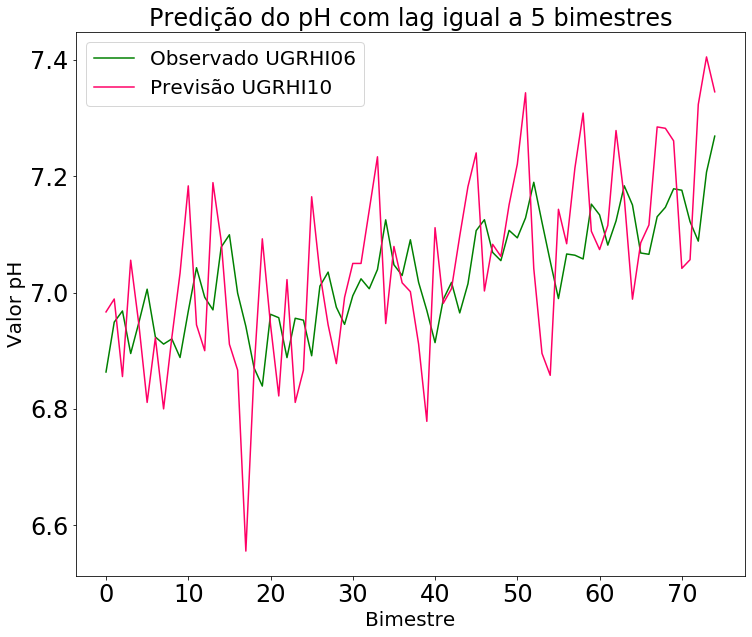

Train on 166 samples
Epoch 1/100
166/166 [==============================] - 0s 2ms/sample - loss: 0.4329 - mean_absolute_error: 0.4329
Epoch 2/100
166/166 [==============================] - 0s 83us/sample - loss: 0.3472 - mean_absolute_error: 0.3472
Epoch 3/100
166/166 [==============================] - 0s 170us/sample - loss: 0.2634 - mean_absolute_error: 0.2634
Epoch 4/100
166/166 [==============================] - 0s 160us/sample - loss: 0.1902 - mean_absolute_error: 0.1902
Epoch 5/100
166/166 [==============================] - 0s 102us/sample - loss: 0.1402 - mean_absolute_error: 0.1402
Epoch 6/100
166/166 [==============================] - 0s 134us/sample - loss: 0.1381 - mean_absolute_error: 0.1381
Epoch 7/100
166/166 [==============================] - 0s 94us/sample - loss: 0.1440 - mean_absolute_error: 0.1440
Epoch 8/100
166/166 [==============================] - 0s 161us/sample - loss: 0.1406 - mean_absolute_error: 0.1406
Epoch 9/100
166/166 [==============================] - 

166/166 [==============================] - 0s 176us/sample - loss: 0.1090 - mean_absolute_error: 0.1090
Epoch 71/100
166/166 [==============================] - 0s 128us/sample - loss: 0.1090 - mean_absolute_error: 0.1090
Epoch 72/100
166/166 [==============================] - 0s 153us/sample - loss: 0.1084 - mean_absolute_error: 0.1084
Epoch 73/100
166/166 [==============================] - 0s 93us/sample - loss: 0.1085 - mean_absolute_error: 0.1085
Epoch 74/100
166/166 [==============================] - 0s 108us/sample - loss: 0.1084 - mean_absolute_error: 0.1084
Epoch 75/100
166/166 [==============================] - 0s 298us/sample - loss: 0.1090 - mean_absolute_error: 0.1090
Epoch 76/100
166/166 [==============================] - 0s 199us/sample - loss: 0.1076 - mean_absolute_error: 0.1076
Epoch 77/100
166/166 [==============================] - 0s 163us/sample - loss: 0.1089 - mean_absolute_error: 0.1089
Epoch 78/100
166/166 [==============================] - 0s 159us/sample - loss

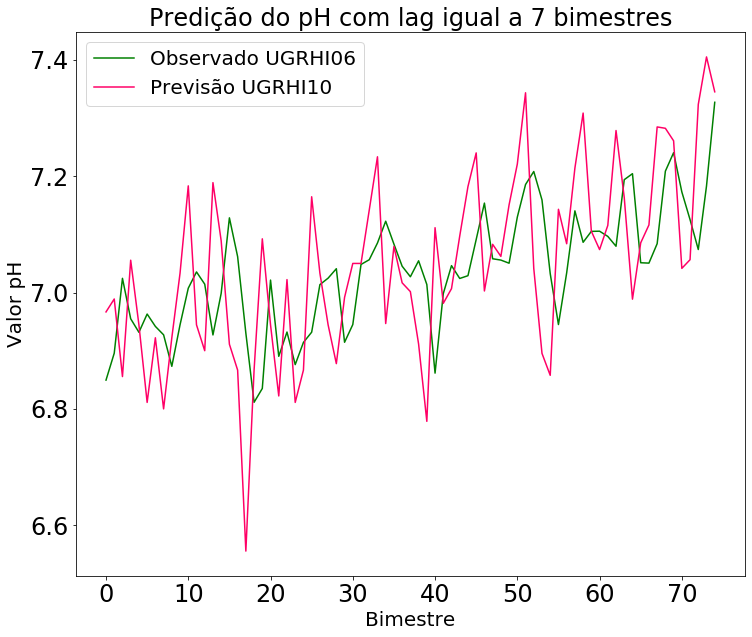

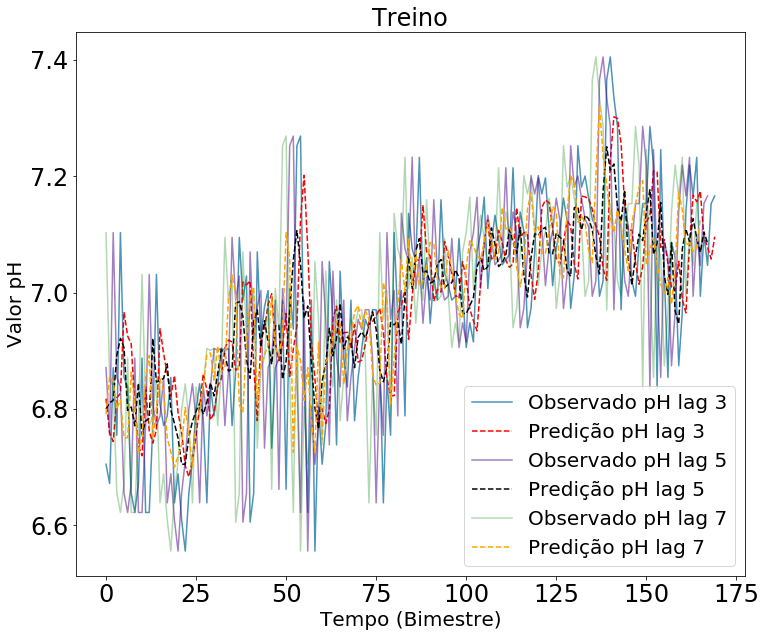

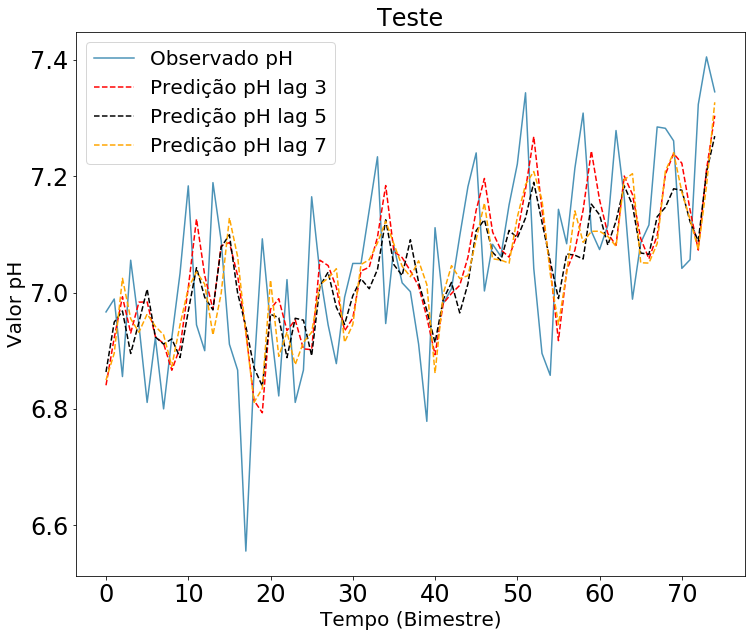

In [25]:
for l in range(3, 9, 2):
    
    lags = l
    #Prepara os dados de treinamento
    X_train10, y_train10 = prepara_dados(train10, lags)
    
    #Prepara os dados de teste
    entradas10 = ugrhi10[len(ugrhi10) - len(test10) - lags:].values
    entradas10 = entradas10.reshape(-1, 1)
    entradas10 = sc.fit_transform(entradas10)

    X_test10 = []
    for i in range(lags, lags+len(test10)):
        X_test10.append(entradas10[i-lags:i, 0])
    X_test10 = np.array(X_test10)
    
    #Prepara os dados de teste06
    entradas06 = ugrhi06[len(ugrhi06) - len(test06) - lags:].values
    entradas06 = entradas06.reshape(-1, 1)
    entradas06 = sc.fit_transform(entradas06)

    X_test06 = []
    for i in range(lags, lags+len(test06)):
        X_test06.append(entradas06[i-lags:i, 0])
    X_test06 = np.array(X_test06)
    
    model = Sequential()
    model.add(Dense(units = 10, activation = 'relu', input_dim = lags))
    model.add(Dense(units = 21, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'linear'))
    model.compile(loss = 'mean_absolute_error', optimizer = 'adam',
                  metrics = ['mean_absolute_error'])

    #Treina o modelo
    model.fit(X_train10, y_train10, batch_size = 32, epochs = 100)
    
    #Predição dos dados de teste
    y_pred10 = model.predict(X_test06)
    y_pred10 = y_pred10.reshape(-1, 1)
    y_pred10 = sc.inverse_transform(y_pred10)
    
    #Predição dos dados de treino
    y_pred10t = model.predict(X_train10)
    y_pred10t = y_pred10t.reshape(-1, 1)
    y_pred10t = sc.inverse_transform(y_pred10t)
    
    y_train10 = y_train10.reshape(-1, 1)
    treino = sc.inverse_transform(y_train10)
    
    #Plotagem do gráfico
    print('Gráficos com lag', l)
    plt.plot(y_pred10, color = 'green', label = 'Observado UGRHI06')
    plt.plot(teste_observado, color = '#ff0066', label = 'Previsão UGRHI10')
    plt.title('Predição do pH com lag igual a ' + str(l) + ' bimestres')
    plt.xlabel('Bimestre')
    plt.ylabel('Valor pH')
    plt.legend()
    plt.show()
    
    if l == 3:
        observado_treino_a = treino
        previsoes_treino_a = y_pred10t
        previsoes_a        = y_pred10
        
        mape_treino_a        = round(mape(y_pred10t,treino)[0],4)
        rmse_treino_a        = round(rmse(y_pred10t,treino),4)
        r_treino_a           = round(r2(y_pred10t,treino),4)
        
        mape_teste_a        = round(mape(y_pred10,teste_observado)[0],4)
        rmse_teste_a        = round(rmse(y_pred10,teste_observado),4)
        r_teste_a           = round(r2(y_pred10,teste_observado),4)
        
    elif l == 5:
        observado_treino_b = treino
        previsoes_treino_b = y_pred10t
        previsoes_b        = y_pred10
        
        mape_treino_b        = round(mape(y_pred10t,treino)[0],4)
        rmse_treino_b        = round(rmse(y_pred10t,treino),4)
        r_treino_b           = round(r2(y_pred10t,treino),4)
        
        mape_teste_b        = round(mape(y_pred10,teste_observado)[0],4)
        rmse_teste_b        = round(rmse(y_pred10,teste_observado),4)
        r_teste_b           = round(r2(y_pred10,teste_observado),4)
        
    else:
        observado_treino_c = treino
        previsoes_treino_c = y_pred10t
        previsoes_c        = y_pred10
        
        mape_treino_c        = round(mape(y_pred10t,treino)[0],4)
        rmse_treino_c        = round(rmse(y_pred10t,treino),4)
        r_treino_c           = round(r2(y_pred10t,treino),4)
        
        mape_teste_c        = round(mape(y_pred10,teste_observado)[0],4)
        rmse_teste_c        = round(rmse(y_pred10,teste_observado),4)
        r_teste_c           = round(r2(y_pred10,teste_observado),4)
        
#Plotagem do gráfico
plt.plot(observado_treino_a, color = '#006699', alpha=0.7, label = 'Observado pH lag 3')
plt.plot(previsoes_treino_a, color = 'red',linestyle = '--', label = 'Predição pH lag 3')
plt.plot(observado_treino_b, color = 'indigo', alpha=0.5, label = 'Observado pH lag 5')
plt.plot(previsoes_treino_b, color = 'black',linestyle = '--', label = 'Predição pH lag 5')
plt.plot(observado_treino_c, color = 'green', alpha=0.3, label = 'Observado pH lag 7')
plt.plot(previsoes_treino_c, color = 'orange',linestyle = '--', label = 'Predição pH lag 7')
plt.title('Treino')
plt.xlabel('Tempo (Bimestre)')
plt.ylabel('Valor pH')
plt.legend()
plt.show()

#Plotagem do gráfico
#plt.plot(data, color = '#006699',alpha=0.5, label = 'Observado')
plt.plot(teste_observado, color = '#006699', alpha=0.7, label = 'Observado pH')
plt.plot(previsoes_a, color = 'red',linestyle = '--', label = 'Predição pH lag 3')
plt.plot(previsoes_b, color = 'black',linestyle = '--', label = 'Predição pH lag 5')
plt.plot(previsoes_c, color = 'orange',linestyle = '--', label = 'Predição pH lag 7')
plt.title('Teste')
plt.xlabel('Tempo (Bimestre)')
plt.ylabel('Valor pH')
plt.legend()
plt.show()


# intialise data of lists.
data_treino = {'Lags':[3, 5, 7],
        'MAPE':[mape_treino_a, mape_treino_b, mape_treino_c],
        'RMSE':[rmse_treino_a, rmse_treino_b, rmse_treino_c],
        'R²':[r_treino_a, r_treino_b, r_treino_c],
        'TIPO':['TREINO', 'TREINO', 'TREINO']}

# intialise data of lists.
data_teste = {'Lags':[3, 5, 7],
        'MAPE':[mape_teste_a, mape_teste_b, mape_teste_c],
        'RMSE':[rmse_teste_a, rmse_teste_b, rmse_teste_c],
        'R²':[r_teste_a, r_teste_b, r_teste_c],
        'TIPO':['TESTE', 'TESTE', 'TESTE']}
 
# Create DataFrame
df_resultados_treino = pd.DataFrame(data_treino)
df_resultados_teste = pd.DataFrame(data_teste)
    

In [26]:
df_resultados_treino

,Lags,MAPE,RMSE,R²,TIPO
0,3,2.4405,0.1376,0.4332,TREINO
1,5,2.4418,0.1359,0.4379,TREINO
2,7,2.1500,0.1272,0.5081,TREINO


In [27]:
df_resultados_teste

,Lags,MAPE,RMSE,R²,TIPO
0,3,1.2582,0.1431,0.1753,TESTE
1,5,1.2039,0.1387,0.2249,TESTE
2,7,1.2190,0.1406,0.2037,TESTE
